In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_theme(style="white")

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.cluster import KMeans, SpectralClustering

from scipy.spatial.distance import directed_hausdorff, euclidean, cosine, pdist
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score

from src.downsample import downsamp_audio
import src.dimension_reducer as dr
import src.distance_metrics as dm
import src.plotting as plotting
import src.emb_manipulator as em


from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

#Directory where already-generated embeddings stored
embedding_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings'

file = '03016_diarized_pyv2.csv'
emb = pd.read_csv(os.path.join(embedding_dir,file), index_col=0)
emb_down_unscaled = em.resample_data(emb,1)

#average emebdding for each participant
emb_a = em.embedding_averager(emb_down_unscaled)

#egemap (88 features) for each participant
gemap_file = '040122_segmented_postpartum_moms_gemaps_2sec.csv'
gemap_unscaled = pd.read_csv(os.path.join(embedding_dir,gemap_file), index_col=0)
gemap_unscaled = gemap_unscaled.drop(columns=['start','end'])


scaler = StandardScaler()
emb_down = pd.DataFrame(scaler.fit_transform(emb_down_unscaled.drop(columns='part_id')))
emb_down['part_id'] = emb_down_unscaled.part_id.to_numpy()

gemap = pd.DataFrame(scaler.fit_transform(gemap_unscaled.drop(columns='part_id')))
gemap['part_id'] = gemap_unscaled.part_id.to_numpy()

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [17]:
emb_down.describe()

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,part_id
count,9.660000e+02,9.660000e+02,9.660000e+02,9.660000e+02,9.660000e+02,9.660000e+02,9.660000e+02,9.660000e+02,9.660000e+02,9.660000e+02,...,9.660000e+02,9.660000e+02,9.660000e+02,9.660000e+02,9.660000e+02,9.660000e+02,9.660000e+02,9.660000e+02,9.660000e+02,966.000000
mean,3.304170e-08,4.106304e-08,-2.326185e-08,1.046629e-08,1.011921e-08,-8.484098e-09,-2.307675e-08,1.604266e-09,-1.350051e-07,5.133651e-08,...,5.705942e-08,-8.181755e-08,2.048524e-08,-8.928356e-08,1.209370e-08,-3.097467e-08,-3.319596e-08,3.658960e-08,1.542563e-10,10.851967
std,1.000518e+00,1.000518e+00,1.000518e+00,1.000518e+00,1.000518e+00,1.000518e+00,1.000518e+00,1.000518e+00,1.000518e+00,1.000518e+00,...,1.000518e+00,1.000518e+00,1.000518e+00,1.000518e+00,1.000518e+00,1.000518e+00,1.000518e+00,1.000519e+00,1.000518e+00,5.875021
min,-3.040995e+00,-3.298738e+00,-2.767253e+00,-4.129851e+00,-3.182607e+00,-3.096869e+00,-3.674523e+00,-3.257917e+00,-2.996882e+00,-3.086407e+00,...,-2.820395e+00,-3.164428e+00,-2.800363e+00,-2.999595e+00,-3.064058e+00,-2.772502e+00,-3.258369e+00,-3.149587e+00,-2.868277e+00,1.000000
25%,-6.477692e-01,-6.992089e-01,-7.190712e-01,-6.520488e-01,-6.657583e-01,-7.133949e-01,-7.167305e-01,-6.626654e-01,-6.246542e-01,-6.515500e-01,...,-6.952080e-01,-6.575707e-01,-6.860532e-01,-6.706152e-01,-6.812201e-01,-6.610569e-01,-7.016014e-01,-6.761014e-01,-6.758031e-01,6.000000
50%,2.903727e-02,-3.306833e-02,-8.071900e-02,-4.908694e-03,-1.411665e-02,1.401568e-02,-5.697988e-02,-2.121140e-02,4.748499e-02,2.241761e-02,...,-5.437953e-02,9.397911e-03,4.736228e-03,-1.533564e-02,-1.422374e-02,3.985012e-02,-7.351462e-02,-1.184811e-02,-4.262494e-02,10.000000
75%,7.314082e-01,6.586506e-01,6.969606e-01,6.395846e-01,6.865110e-01,6.662395e-01,7.011242e-01,6.759794e-01,6.675207e-01,6.461660e-01,...,6.790304e-01,6.454129e-01,6.668080e-01,6.691243e-01,6.386942e-01,7.148208e-01,6.979304e-01,6.723110e-01,6.112279e-01,17.000000
max,3.240296e+00,3.989408e+00,3.614243e+00,3.012626e+00,3.400843e+00,3.171230e+00,3.359339e+00,3.257129e+00,3.047198e+00,2.868465e+00,...,3.000404e+00,2.887082e+00,2.967835e+00,4.203912e+00,4.151534e+00,2.676132e+00,3.409570e+00,3.026239e+00,3.253700e+00,20.000000


In [3]:
#average emebdding for each participant
emb_a = em.embedding_averager(emb_down)
cos_dist_high_dim = dm.cos_distance(emb_a)

Processing row 19, col 19


In [11]:
sil_score = metrics.silhouette_score(emb_down.drop(columns='part_id'), emb_down.part_id, metric='cosine')
sil_score

0.17576145

In [15]:
adjusted_rand_score(emb_down_kmeans.part_id, emb_down_kmeans.kmeans_predict)

0.8573114846800858

In [3]:
emb_down_kmeans = emb_down
emb_down_kmeans['kmeans_predict'] = KMeans(n_clusters=20, random_state=42).fit_predict(emb_down.drop(columns='part_id'))

In [59]:
true_group = emb_down_kmeans.groupby('part_id')

count = {}
for name, embeddings in true_group:
    if (embeddings['kmeans_predict'].to_numpy()[0] == embeddings['kmeans_predict']).all():
        #print(embeddings['kmeans_predict'] == embeddings['kmeans_predict'].iloc[0])
        count[name] = True
    else:
        tot = sum(embeddings['kmeans_predict'].to_numpy()[0] == embeddings['kmeans_predict'])/embeddings['kmeans_predict'].shape[0]
        count[name] = tot

In [60]:
count

{1.0: True,
 2.0: 0.7884615384615384,
 3.0: True,
 4.0: True,
 5.0: 0.9523809523809523,
 6.0: 0.7638888888888888,
 7.0: 0.975,
 8.0: True,
 9.0: 0.9701492537313433,
 10.0: 0.9696969696969697,
 11.0: 0.9387755102040817,
 12.0: 0.25925925925925924,
 13.0: True,
 14.0: True,
 15.0: 0.9767441860465116,
 16.0: 0.84,
 17.0: 0.6875,
 18.0: True,
 19.0: True,
 20.0: True}

<AxesSubplot:>

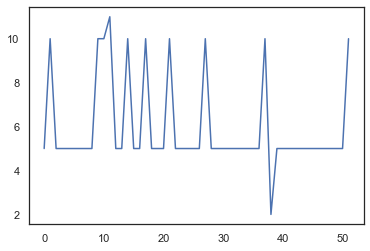

In [54]:
a = emb_down_kmeans[emb_down_kmeans.part_id==2][['kmeans_predict']]
sns.lineplot(x = np.arange(a.shape[0]), y = a.values.flatten())

In [4]:
#max global structure
perplexity = 135
learning_rate = 200

#default
#n_neighbors = 10
#dist=0.1

#max global structure
n_neighbors=14
dist=10E-3

###Run dimension reduction with different methods on the embeddings to establish a baseline before leaving any participants out
#Using tsne with perplexity=30 (default) since N/100<30, and learning rate of n/12. Random seed is 42 so the result is the same each time
#emb_tsne = dr.run_tsne(emb_down, perplexity = perplexity, init='pca', learning_rate=learning_rate)
#PCA Initializer of TSNE
pca = PCA(n_components=50)
emb_pca = pd.DataFrame(pca.fit_transform(emb_down.drop(columns='part_id')))
emb_pca['part_id'] = emb_down.part_id
emb_tsne = dr.run_tsne(emb_pca, perplexity = perplexity, learning_rate=learning_rate)


#run umap with default parameters
emb_umap = dr.run_umap(emb_down, n_neighbors=n_neighbors, dist=dist)


labels = emb_down.part_id

#PACMAP for comparison
emb_pacmap = dr.run_pacmap(emb_down)


#PCA for comparison
#pca = PCA(n_components=512)
#exp_var = pca.fit(emb_down.drop(columns='part_id')).explained_variance_ratio_
#emb_pca = pd.DataFrame(pca.fit_transform(emb_down.drop(columns='part_id')))
#emb_pca = emb_pca.iloc[:,:2]
#emb_pca.columns = ['dim0', 'dim1']

#measure 'knn', 'knc', 'cpd' to determine how well micro, meso, and marco structure of high-D preserved by dim reduction, per Kobak&Berens2019
knn=50
knn_classes=4
subsetsize=700

#we are always comparing to emb_down as our high-dimension embedding. 
high_dim = emb_down.drop(columns='part_id').to_numpy()
classes= emb_down.part_id.to_numpy() #extract the categories/labels

#compare tsne to embeddings
low_dim = emb_tsne.drop(columns='part_id').to_numpy()
dist_tsne = dm.embedding_quality(high_dim, low_dim, classes, knn=knn, knn_classes=knn_classes, subsetsize=subsetsize)

#compare umap to embeddings
low_dim = emb_umap.drop(columns='part_id').to_numpy()
dist_umap = dm.embedding_quality(high_dim, low_dim, classes, knn=knn, knn_classes=knn_classes, subsetsize=subsetsize)

#comapre pacmap to embeddings
low_dim = emb_pacmap.to_numpy()
dist_pacmap = dm.embedding_quality(high_dim, low_dim, classes,  knn=knn,  knn_classes=knn_classes, subsetsize=subsetsize)

#compare pca to embeddings
low_dim = emb_pca.to_numpy()
dist_pca = dm.embedding_quality(high_dim, low_dim, classes,  knn=knn,  knn_classes=knn_classes, subsetsize=subsetsize)

#create a dataframe of all distance metrics for each dimension method
dist = pd.DataFrame(np.vstack((dist_tsne, dist_umap,dist_pacmap,dist_pca)), columns = ['micro', 'meso', 'macro'], index = ['tsne', 'umap', 'pacmap','pca'])
dist = dist.round(decimals=3)

In [12]:
tsne_cluster_test = KMeans(n_clusters=20, random_state=42).fit_predict(emb_tsne.drop(columns='part_id'))
umap_cluster_test = KMeans(n_clusters=20, random_state=42).fit_predict(emb_umap.drop(columns='part_id'))

In [8]:
adjusted_rand_score(emb_down_kmeans.part_id, umap_cluster_test)

NameError: name 'emb_down_kmeans' is not defined

[Text(0.5, 1.0, 'labeled by participant ID\n      micro   meso  macro\numap  0.552  0.462  0.316')]

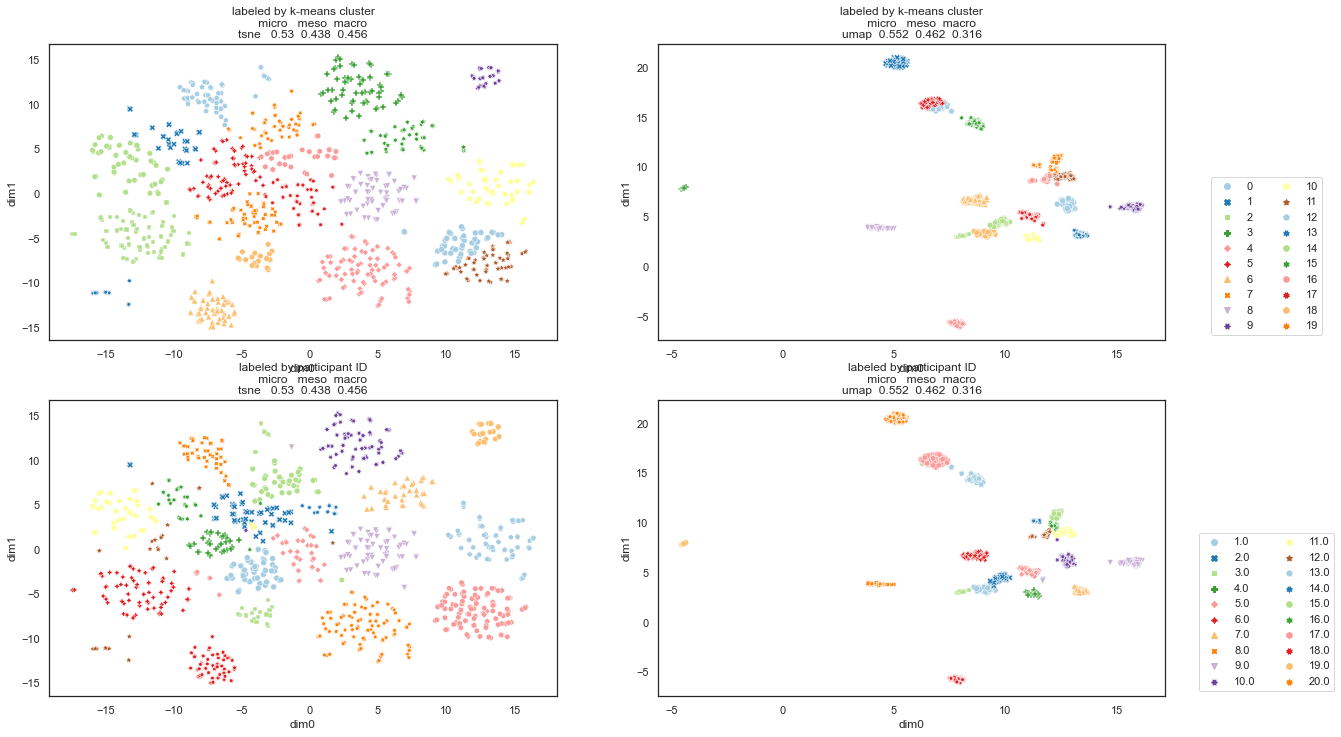

In [13]:
##plot 2 dimensions from each dimension reduction
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20,12))

clust_plt_tsne = sns.scatterplot(x=emb_tsne.dim0, y=emb_tsne.dim1, ax=ax1, palette="Paired", hue=tsne_cluster_test, style=tsne_cluster_test, legend=False)
#ax1.legend(loc="lower center",bbox_to_anchor=(1.3,1), ncol=2)
clust_plt_tsne.set(title = 'labeled by k-means cluster\n' + str(dist[dist.index=='tsne']))

clust_plt_umap = sns.scatterplot(x=emb_umap.dim0, y=emb_umap.dim1, ax=ax2, palette="Paired", hue=umap_cluster_test,style=umap_cluster_test, legend=True)
ax2.legend(loc="lower center",bbox_to_anchor=(1.2, 0), ncol=2)
clust_plt_umap.set(title = 'labeled by k-means cluster\n' + str(dist[dist.index=='umap']))

clust_plt_tsne_2 = sns.scatterplot(x=emb_tsne.dim0, y=emb_tsne.dim1, ax=ax3, palette="Paired", hue=emb_tsne.part_id, style=emb_tsne.part_id, legend=False)
#ax1.legend(loc="lower center",bbox_to_anchor=(1.3,1), ncol=2)
clust_plt_tsne_2.set(title = 'labeled by participant ID\n' + str(dist[dist.index=='tsne']))

clust_plt_umap_2 = sns.scatterplot(x=emb_umap.dim0, y=emb_umap.dim1, ax=ax4, palette="Paired", hue=emb_umap.part_id, style=emb_tsne.part_id, legend=True)
ax4.legend(loc="lower center",bbox_to_anchor=(1.2, 0), ncol=2)
clust_plt_umap_2.set(title = 'labeled by participant ID\n' + str(dist[dist.index=='umap']))

[Text(0.5, 1.0, '     micro  meso  macro\npca  0.423  0.55  0.481')]

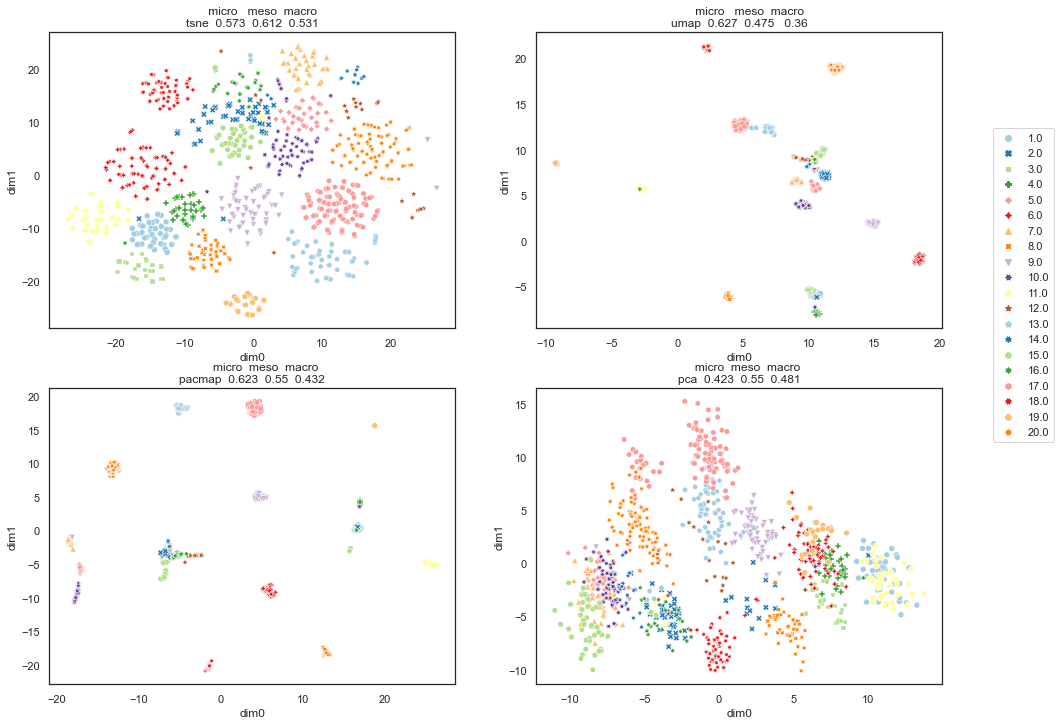

In [3]:
#construct dictonary of leaving each participant
part_list = emb_a.part_id.unique().astype('int32') 

#loo is leave one out. Creates a dictionary of the downsampled embeddings with the format: {participant_removed:embeddings} for each participant
loo = {p:
       emb_a[emb_a.part_id!=part_list[idx]].reset_index(drop=True) 
       for idx,p in enumerate(part_list)
      }

loo_cos_dist = {rm:dm.cos_distance(e_a) for rm, e_a in loo.items()}

Processing row 18, col 18


In [5]:
for p in loo_cos_dist.keys():  
    loo_cos_dist[p].loc[p] = np.nan
    loo_cos_dist[p].sort_index(inplace=True)
    loo_cos_dist[p][p] = np.nan
    loo_cos_dist[p] = loo_cos_dist[p].reindex(sorted(loo_cos_dist[p].columns), axis=1)


In [8]:
flat_loss_cos_dist = {rm:pd.DataFrame(h.to_numpy().flatten()) for rm, h in loo_cos_dist.items()}

In [12]:
corr_coeff = pd.DataFrame()
df1 = pd.DataFrame(cos_dist_high_dim.to_numpy().flatten())
for haus in flat_loss_cos_dist.values():
    #haus = pd.DataFrame(haus)
    corr_coeff = pd.concat([corr_coeff, df1.corrwith(haus)], ignore_index=True)
corr_coeff['rm'] = flat_loss_cos_dist.keys()

ValueError: Data must be 1-dimensional

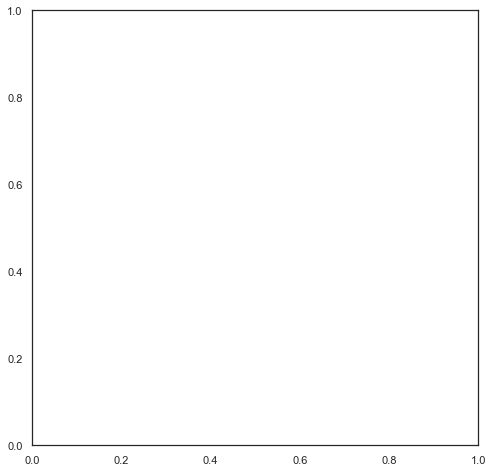

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
[sns.scatterplot(
    x=df1.to_numpy(), y=dist.to_numpy(), palette="Paired", 
    ) 
 for dist in flat_loss_cos_dist.values()]

plt.xlim([-3,3])
plt.ylim([-3,3])

sns.lineplot(x=[-3,3], y=[-3,3])
plt.show()